In [1]:
import pandas as pd
import janitor
from utilities import save_mpl_fig

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

sns.set_theme(context="notebook", font_scale=1.35, style="whitegrid", palette="dark")

from inequality.gini import Gini

## Prep

In [2]:
df = (
    pd.read_csv("../data/6.3m-ind-domain-data.csv.gz")
    .rename_column("visit_duration", "duration")
    .assign(
        duration_min=lambda df_: df_["duration"] / 60,
        duration_hr=lambda df_: df_["duration"] / 3600,
    )
    # ==================================================
    # Merge to VT
    .merge(
        (pd.read_csv("../data/yg_virustotal_dat.csv")),
        how="left",
        left_on="private_domain",
        right_on="filename",
        validate="m:1",
    )
    .assign(
        malicious_bool=lambda df_: np.where(df_["malicious"] >= 2, True, False),
        malicious_min=lambda df_: df_["malicious_bool"] * df_["duration_min"],
        malicious_hr=lambda df_: df_["malicious_bool"] * df_["duration_hr"],
        suspicious_bool=lambda df_: df_["suspicious"].astype("bool"),
    )
    # ==================================================
)
display(df.head())
df.info()

,caseid,private_domain,category,visit_time_local,duration,duration_min,duration_hr,filename,harmless,malicious,...,timeout,forcepoint,sophos,bitdefender,comodo,alphamnt,malicious_bool,malicious_min,malicious_hr,suspicious_bool
0,205323077,google.com,Search Engines and Portals,2022-05-31 23:52:37,2,0.033333,0.000556,google.com,70.0,0.0,...,0.0,search engines and portals,search engines,searchengines,NaN,NaN,False,0.0,0.0,False
1,205323077,coupons.com,"Business, Shopping",2022-06-01 01:07:35,457,7.616667,0.126944,coupons.com,68.0,0.0,...,0.0,shopping,online shopping,ads,NaN,"Marketing/Merchandising, Shopping",False,0.0,0.0,False
2,205323077,google.com,Business,2022-06-01 01:15:12,55,0.916667,0.015278,google.com,70.0,0.0,...,0.0,search engines and portals,search engines,searchengines,NaN,NaN,False,0.0,0.0,False
3,205323077,coupons.com,"Business, Shopping",2022-06-01 01:16:07,2225,37.083333,0.618056,coupons.com,68.0,0.0,...,0.0,shopping,online shopping,ads,NaN,"Marketing/Merchandising, Shopping",False,0.0,0.0,False
4,205323077,google.com,Search Engines and Portals,2022-06-01 04:38:10,10,0.166667,0.002778,google.com,70.0,0.0,...,0.0,search engines and portals,search engines,searchengines,NaN,NaN,False,0.0,0.0,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6297382 entries, 0 to 6297381
Data columns (total 22 columns):
 #   Column            Dtype  
---  ------            -----  
 0   caseid            int64  
 1   private_domain    object 
 2   category          object 
 3   visit_time_local  object 
 4   duration          int64  
 5   duration_min      float64
 6   duration_hr       float64
 7   filename          object 
 8   harmless          float64
 9   malicious         float64
 10  suspicious        float64
 11  undetected        float64
 12  timeout           float64
 13  forcepoint        object 
 14  sophos            object 
 15  bitdefender       object 
 16  comodo            object 
 17  alphamnt          object 
 18  malicious_bool    bool   
 19  malicious_min     float64
 20  malicious_hr      float64
 21  suspicious_bool   bool   
dtypes: bool(2), float64(9), int64(2), object(9)
memory usage: 972.9+ MB


## Singletons

In [3]:
(
    df.query("malicious_bool")
    .groupby("caseid")["private_domain"]
    .size()
    #     .groupby(["caseid", "private_domain", "malicious"])
    #     .size()
    #     .reset_index()
    #     .rename_column(0, "visits")
    #     .assign(singleton=lambda df_: np.where(df_["visits"]==1, 1, 0))
    #     .groupby("caseid")["singleton"].mean()
    #     .reset_index()
)

caseid
47541         4
257495       19
296069       99
345485       29
359503        9
             ..
342368009     2
342376013     7
343144813     3
343195461     2
343466645    63
Name: private_domain, Length: 582, dtype: int64

### Malicious

In [4]:
df_ind_mal = (
    df.query("malicious_bool")
    .groupby(["caseid", "private_domain"])
    .size()
    .reset_index()
    .rename_column(0, "visits")
    .assign(singleton=lambda df_: np.where(df_["visits"] == 1, 1, 0))
    .groupby("caseid")["singleton"]
    .mean()
    .reset_index()
)
df_ind_mal

,caseid,singleton
0,47541,0.00
1,257495,0.00
2,296069,0.05
3,345485,0.00
4,359503,0.20
...,...,...
577,342368009,0.00
578,342376013,0.00
579,343144813,0.00
580,343195461,0.00


<Axes: xlabel='singleton', ylabel='Count'>

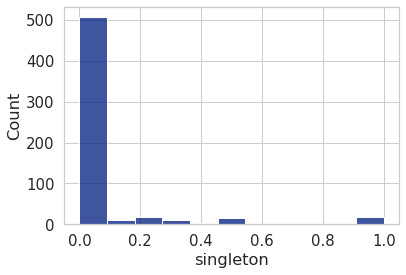

In [5]:
sns.histplot(df_ind_mal["singleton"])

In [6]:
df_ind_mal.query("singleton==1").reset_index(drop=True)

,caseid,singleton
0,1356687,1.0
1,2786281,1.0
2,8559845,1.0
3,51376843,1.0
4,54220201,1.0
5,56463825,1.0
6,68422217,1.0
7,85140081,1.0
8,210158485,1.0
9,247699957,1.0


### Non-malicious

In [7]:
df_ind_nonmal = (
    df.query("malicious==0")
    .query("suspicious==0")
    .groupby(["caseid", "private_domain"])
    .size()
    .reset_index()
    .rename_column(0, "visits")
    .assign(singleton=lambda df_: np.where(df_["visits"] == 1, 1, 0))
    .groupby("caseid")["singleton"]
    .mean()
    .reset_index()
)
df_ind_nonmal

,caseid,singleton
0,47541,0.031776
1,56565,0.015576
2,203271,0.035211
3,216457,0.020833
4,257495,0.003906
...,...,...
1129,342376013,0.018868
1130,342383477,0.078947
1131,343144813,0.105263
1132,343195461,0.125000


<Axes: xlabel='singleton', ylabel='Count'>

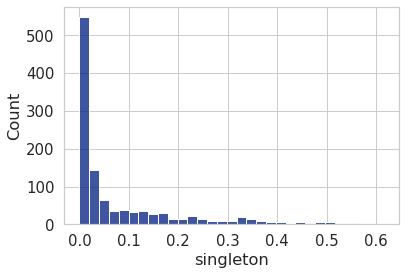

In [8]:
sns.histplot(df_ind_nonmal["singleton"])

### Plot

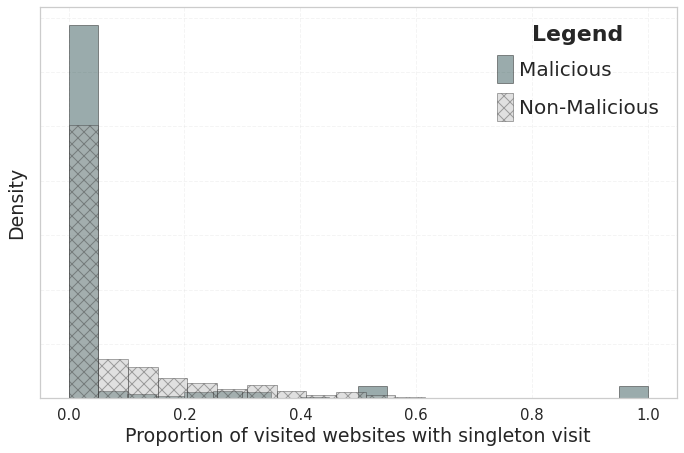

In [9]:
_scale = 0.8
_aspect_ratio = (12, 8)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

ax.hist(
    df_ind_mal["singleton"],
    bins=20,
    alpha=0.4,
    label="Malicious",
    color="#032f30",
    edgecolor="black",
    density=True,
)

ax.hist(
    df_ind_nonmal["singleton"],
    bins=12,
    alpha=0.4,
    label="Non-Malicious",
    color=".7",
    edgecolor=".2",
    hatch="xx",
    density=True,
)

ax.set_ylabel("Density", fontsize=19)
ax.set_xlabel("Proportion of visited websites with singleton visit", fontsize=19)
ax.set_yticklabels([])

plt.legend(
    title="Legend",
    loc="upper right",
    fontsize=20,
    title_fontproperties={"weight": "bold", "size": 22},
    frameon=False,
    handlelength=0.8,
    handleheight=1.8,
    handletextpad=0.3,
    labelspacing=0.5,
)
plt.grid(True, linestyle="--", alpha=0.2)
plt.tight_layout()
save_mpl_fig("../figs/hist-mal-nonmal-prop-singleton-visit-websites")

## Concentration

### Malicious

In [11]:
df_mal_ginis = (
    df.query("malicious_bool==1")
    .reset_index(drop=True)
    .groupby(["caseid", "private_domain"])
    .size()
    .reset_index()
    .rename_column(0, "visits")
    .groupby("caseid")["visits"]
    .apply(lambda x: Gini(x.values).g)
    .reset_index(name="gini")
    # ------------------------------
    # Get number of unique mal. sizes
    .merge(
        (
            df.query("malicious_bool")
            .groupby("caseid")["private_domain"]
            .size()
            .reset_index(name="uniques")
        ),
        how="left",
        on="caseid",
        validate="1:1",
    )
)
df_mal_ginis

,caseid,gini,uniques
0,47541,0.000000,4
1,257495,0.302632,19
2,296069,0.455051,99
3,345485,0.390805,29
4,359503,0.088889,9
...,...,...,...
577,342368009,0.000000,2
578,342376013,0.000000,7
579,343144813,0.000000,3
580,343195461,0.000000,2


In [23]:
100 * len(df_mal_ginis.query("gini<0.1")) / len(df_mal_ginis)

47.766323024054984

In [24]:
100 * len(df_mal_ginis.query("gini<0.2")) / len(df_mal_ginis)

60.99656357388316

In [28]:
100 * len(df_mal_ginis.query("gini>0.8")) / len(df_mal_ginis)

0.8591065292096219

<Axes: xlabel='gini', ylabel='Count'>

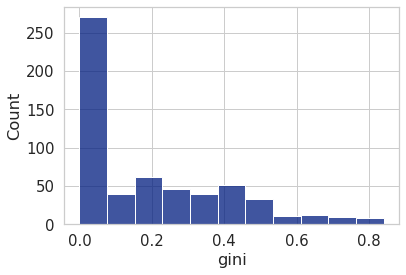

In [12]:
sns.histplot(df_mal_ginis["gini"])

<Axes: xlabel='gini', ylabel='Count'>

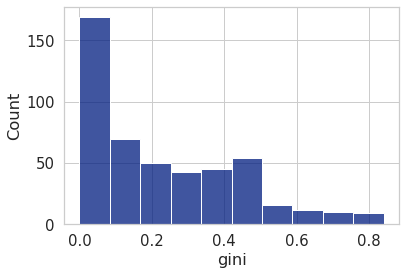

In [13]:
sns.histplot(df_mal_ginis.query("uniques>=3")["gini"])

<Axes: xlabel='gini', ylabel='Count'>

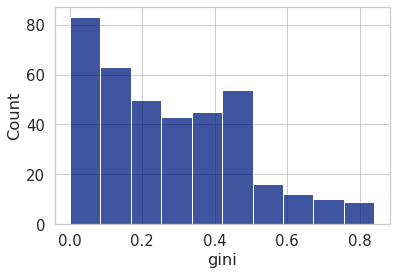

In [14]:
sns.histplot(df_mal_ginis.query("uniques>=5")["gini"])

In [21]:
len(df_mal_ginis.query("uniques>=5"))

385

### Non-malicious

In [15]:
df_nonmal_ginis = (
    df.query("malicious==0")
    .query("suspicious==0")
    .reset_index(drop=True)
    .groupby(["caseid", "private_domain"])
    .size()
    .reset_index()
    .rename_column(0, "visits")
    .groupby("caseid")["visits"]
    .apply(lambda x: Gini(x.values).g)
    .reset_index(name="gini")
    # ------------------------------
    # Get number of unique non-mal. sizes
    .merge(
        (
            df.query("malicious==0")
            .query("suspicious==0")
            .groupby("caseid")["private_domain"]
            .size()
            .reset_index(name="uniques")
        ),
        how="left",
        on="caseid",
        validate="1:1",
    )
)
df_nonmal_ginis

,caseid,gini,uniques
0,47541,0.847685,16383
1,56565,0.841131,11146
2,203271,0.867751,6146
3,216457,0.825226,1768
4,257495,0.858746,9677
...,...,...,...
1129,342376013,0.890564,5561
1130,342383477,0.771171,867
1131,343144813,0.834694,767
1132,343195461,0.655418,526


<Axes: xlabel='gini', ylabel='Count'>

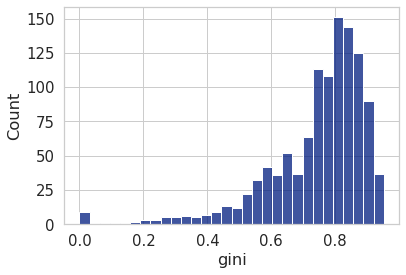

In [16]:
sns.histplot(df_nonmal_ginis["gini"])

<Axes: xlabel='gini', ylabel='Count'>

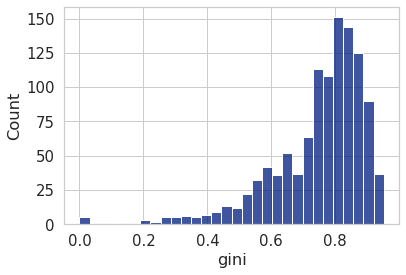

In [17]:
sns.histplot(df_nonmal_ginis.query("uniques>=5")["gini"])

In [29]:
100 * len(df_nonmal_ginis.query("gini<0.1")) / len(df_nonmal_ginis)

0.8818342151675485

In [30]:
100 * len(df_nonmal_ginis.query("gini<0.2")) / len(df_nonmal_ginis)

1.3227513227513228

In [32]:
100 * len(df_nonmal_ginis.query("gini>0.8")) / len(df_nonmal_ginis)

44.79717813051146

### Plot

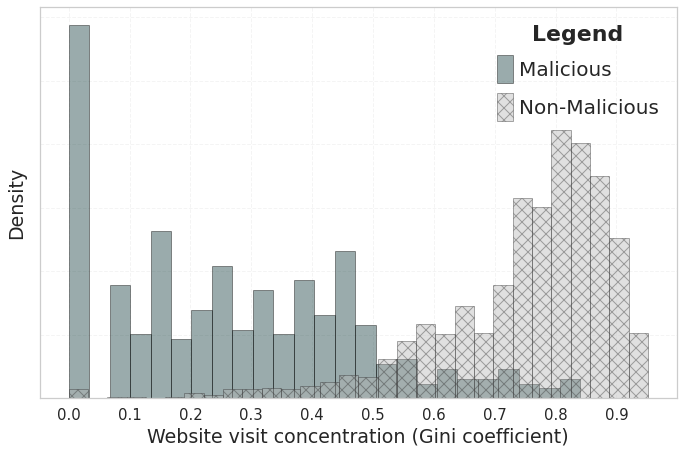

In [18]:
_scale = 0.8
_aspect_ratio = (12, 8)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

ax.hist(
    df_mal_ginis.query("uniques>=5")["gini"],
    bins=25,
    alpha=0.4,
    label="Malicious",
    color="#032f30",
    edgecolor="black",
    density=True,
)

ax.hist(
    df_nonmal_ginis.query("uniques>=5")["gini"],
    bins=30,
    alpha=0.4,
    label="Non-Malicious",
    color=".7",
    edgecolor=".2",
    hatch="xx",
    density=True,
)

ax.set_ylabel("Density", fontsize=19)
ax.set_xlabel("Website visit concentration (Gini coefficient)", fontsize=19)
ax.set_yticklabels([])
ax.set_xticks(
    [
        0,
        0.1,
        0.2,
        0.3,
        0.4,
        0.5,
        0.6,
        0.7,
        0.8,
        0.9,
    ]
)
# ax.set_xticklabels([0,.1,.2,.3,.4,.5,.6,.7,.8,.9])
plt.legend(
    title="Legend",
    loc="upper right",
    fontsize=20,
    title_fontproperties={"weight": "bold", "size": 22},
    frameon=False,
    handlelength=0.8,
    handleheight=1.8,
    handletextpad=0.3,
    labelspacing=0.5,
)
plt.grid(True, linestyle="--", alpha=0.2)
plt.tight_layout()
save_mpl_fig("../figs/hist-mal-nonmal-gini")

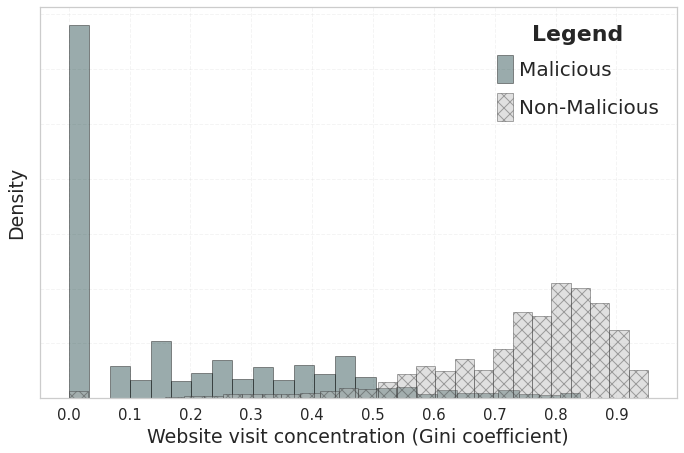

In [22]:
# No restriction on mal
_scale = 0.8
_aspect_ratio = (12, 8)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

ax.hist(
    df_mal_ginis.query("uniques>=0")["gini"],
    bins=25,
    alpha=0.4,
    label="Malicious",
    color="#032f30",
    edgecolor="black",
    density=True,
)

ax.hist(
    df_nonmal_ginis.query("uniques>=0")["gini"],
    bins=30,
    alpha=0.4,
    label="Non-Malicious",
    color=".7",
    edgecolor=".2",
    hatch="xx",
    density=True,
)

ax.set_ylabel("Density", fontsize=19)
ax.set_xlabel("Website visit concentration (Gini coefficient)", fontsize=19)
ax.set_yticklabels([])
ax.set_xticks(
    [
        0,
        0.1,
        0.2,
        0.3,
        0.4,
        0.5,
        0.6,
        0.7,
        0.8,
        0.9,
    ]
)
# ax.set_xticklabels([0,.1,.2,.3,.4,.5,.6,.7,.8,.9])
plt.legend(
    title="Legend",
    loc="upper right",
    fontsize=20,
    title_fontproperties={"weight": "bold", "size": 22},
    frameon=False,
    handlelength=0.8,
    handleheight=1.8,
    handletextpad=0.3,
    labelspacing=0.5,
)
plt.grid(True, linestyle="--", alpha=0.2)
plt.tight_layout()
# save_mpl_fig("../figs/hist-mal-nonmal-gini")